In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [33]:
columns = [
    "class",
    "alcohol",
    "malic_acid",
    "ash",
    "alcalinity_of_ash",
    "magnesium",
    "total_phenols",
    "flavanoids",
    "nonflavanoid_phenols",
    "proanthocyanins",
    "color_intensity",
    "hue",
    "od280/od315_of_diluted_wines",
    "proline"
]

wine = pd.read_csv("./wine/wine.data", header=None, names=columns)

wine.head()

,class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [34]:
#rozdzielanie klas i etykiet danych
X = wine.drop(columns=["class"])
y_true = wine["class"] # tylko do porównania / wizualizacji

In [35]:
#standaryzacja cech - polepsza wynik dbscan
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


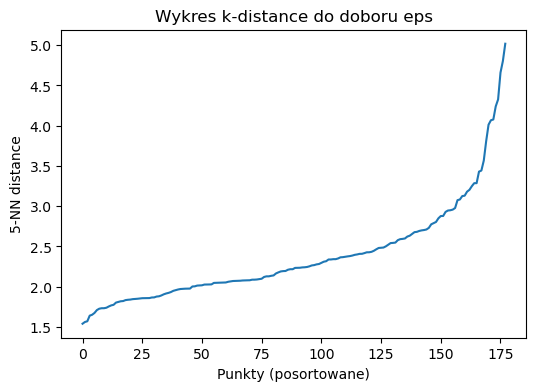

In [36]:
# Wykres do dobrania eps (odległości sąsiadów - wzrost na wykresie)
from sklearn.neighbors import NearestNeighbors

k = 5
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)

distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6,4))
plt.plot(distances)
plt.ylabel(f"{k}-NN distance")
plt.xlabel("Punkty (posortowane)")
plt.title("Wykres k-distance do doboru eps")
plt.show()


In [37]:
#ile klastrów - aby dobrać najlepszee rozwiązanie

for eps in [2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6]:
    labels = DBSCAN(eps=eps, min_samples=5).fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    print(f"eps={eps} → klastry={n_clusters}, szum={n_noise}")


eps=2.0 → klastry=5, szum=85
eps=2.1 → klastry=3, szum=62
eps=2.2 → klastry=2, szum=55
eps=2.3 → klastry=2, szum=42
eps=2.4 → klastry=2, szum=36
eps=2.5 → klastry=1, szum=24
eps=2.6 → klastry=1, szum=20


In [38]:
#klasteryzacja i sprawdzenie wyników dla zbioru wine
dbscan = DBSCAN(eps=2.1, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

wine["cluster"] = clusters

print("Liczba punktów:", len(wine))
print("Liczba klastrów (bez szumu):", len(set(clusters)) - (1 if -1 in clusters else 0))
print("Liczba punktów szumu:", np.sum(clusters == -1))

wine["cluster"].value_counts().sort_index()


Liczba punktów: 178
Liczba klastrów (bez szumu): 3
Liczba punktów szumu: 62


cluster
-1    62
 0    82
 1    13
 2    21
Name: count, dtype: int64

In [39]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

wine["PC1"] = X_pca[:, 0]
wine["PC2"] = X_pca[:, 1]


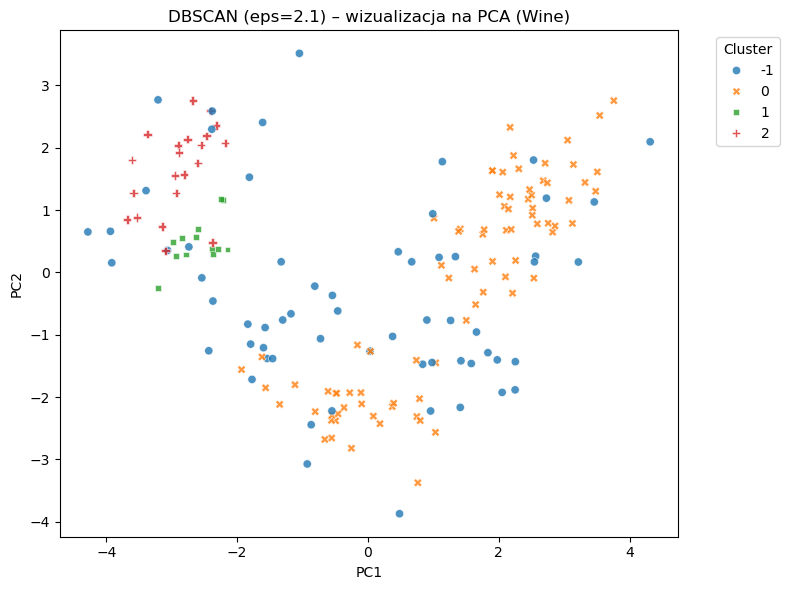

In [40]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=wine,
    x="PC1", y="PC2",
    hue="cluster",
    palette="tab10",
    style="cluster",
    alpha=0.8
)
plt.title("DBSCAN (eps=2.1) - wizualizacja na PCA (Wine)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


C:\Users\artge\.conda\envs\mi-comp\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


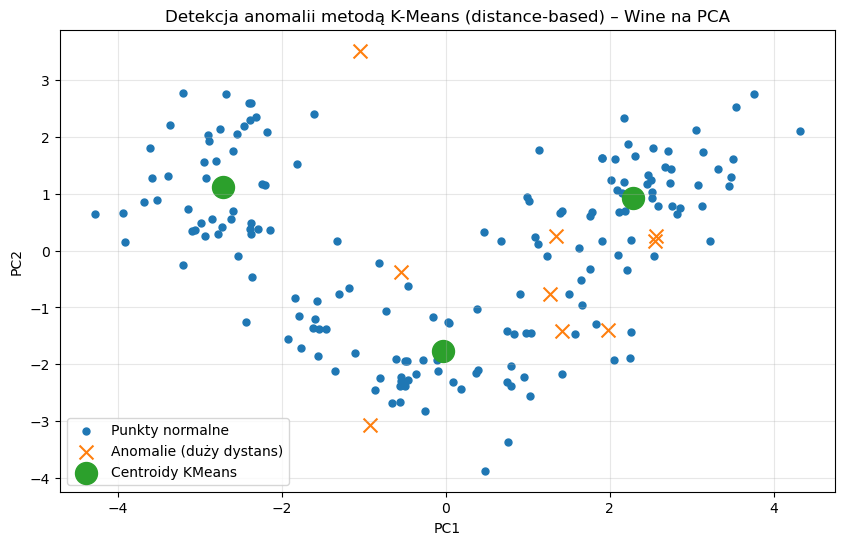

Liczba anomalii: 9
Próg dystansu (95 percentyl): 4.288850556734393


In [41]:
#KMeans na danych standaryzowanych
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
kmeans.fit(X_scaled)

# dystans każdego punktu do centroidu swojego klastra
centra_dla_punktow = kmeans.cluster_centers_[kmeans.labels_]
dystanse = np.linalg.norm(X_scaled - centra_dla_punktow, axis=1)

# próg anomalii
procent_anomalii = 95
threshold = np.percentile(dystanse, procent_anomalii)

czy_anomalia = dystanse > threshold

# centroidy do PCA (żeby je narysować na wykresie PCA)
centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10,6))

# punkty normalne
plt.scatter(
    wine.loc[~czy_anomalia, "PC1"],
    wine.loc[~czy_anomalia, "PC2"],
    s=25,
    label="Punkty normalne"
)

# anomalie
plt.scatter(
    wine.loc[czy_anomalia, "PC1"],
    wine.loc[czy_anomalia, "PC2"],
    s=100,
    marker="x",
    label="Anomalie (duży dystans)"
)

# centroidy
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    s=250,
    label="Centroidy KMeans"
)

plt.title("Detekcja anomalii metodą K-Means (distance-based) - Wine na PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("Liczba anomalii:", czy_anomalia.sum())
print("Próg dystansu (95 percentyl):", threshold)
